In [1]:
%matplotlib inline


# Imputing missing values with variants of IterativeImputer

.. currentmodule:: sklearn

The :class:`~impute.IterativeImputer` class is very flexible - it can be
used with a variety of estimators to do round-robin regression, treating every
variable as an output in turn.

In this example we compare some estimators for the purpose of missing feature
imputation with :class:`~impute.IterativeImputer`:

* :class:`~linear_model.BayesianRidge`: regularized linear regression
* :class:`~tree.DecisionTreeRegressor`: non-linear regression
* :class:`~ensemble.ExtraTreesRegressor`: similar to missForest in R
* :class:`~neighbors.KNeighborsRegressor`: comparable to other KNN
  imputation approaches

Of particular interest is the ability of
:class:`~impute.IterativeImputer` to mimic the behavior of missForest, a
popular imputation package for R. In this example, we have chosen to use
:class:`~ensemble.ExtraTreesRegressor` instead of
:class:`~ensemble.RandomForestRegressor` (as in missForest) due to its
increased speed.

Note that :class:`~neighbors.KNeighborsRegressor` is different from KNN
imputation, which learns from samples with missing values by using a distance
metric that accounts for missing values, rather than imputing them.

The goal is to compare different estimators to see which one is best for the
:class:`~impute.IterativeImputer` when using a
:class:`~linear_model.BayesianRidge` estimator on the California housing
dataset with a single value randomly removed from each row.

For this particular pattern of missing values we see that
:class:`~ensemble.ExtraTreesRegressor` and
:class:`~linear_model.BayesianRidge` give the best results.


In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

Automatically created module for IPython interactive environment


In [6]:
X_full, y_full = fetch_california_housing(return_X_y=True)
X_full.shape, X_full[::10].shape,  y_full[::10].shape

((20640, 8), (2064, 8), (2064,))

In [9]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

In [10]:
score_full_data

,Full Data
0,-0.408433
1,-0.636009
2,-0.614910
3,-1.089616
4,-0.407541


In [11]:
# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )


In [12]:
score_simple_imputer

,mean,median
0,-0.581144,-0.597054
1,-0.806046,-0.823622
2,-0.764460,-0.762791
3,-1.319445,-1.281915
4,-0.663177,-0.698396


In [17]:
import warnings
warnings.filterwarnings('ignore')

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )



In [18]:
score_iterative_imputer

,BayesianRidge,DecisionTreeRegressor,ExtraTreesRegressor,KNeighborsRegressor
0,-0.491962,-0.556094,-0.468117,-0.591408
1,-0.774114,-0.783482,-0.710690,-0.817013
2,-0.736444,-0.736776,-0.682888,-0.772740
3,-0.899903,-1.240339,-1.181990,-1.329922
4,-0.574412,-0.562786,-0.472711,-0.662786


In [19]:
scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)


In [20]:
scores

Original SimpleImputer           IterativeImputer                        \
  Full Data          mean    median    BayesianRidge DecisionTreeRegressor   
0 -0.408433     -0.581144 -0.597054        -0.491962             -0.556094   
1 -0.636009     -0.806046 -0.823622        -0.774114             -0.783482   
2 -0.614910     -0.764460 -0.762791        -0.736444             -0.736776   
3 -1.089616     -1.319445 -1.281915        -0.899903             -1.240339   
4 -0.407541     -0.663177 -0.698396        -0.574412             -0.562786   

                                           
  ExtraTreesRegressor KNeighborsRegressor  
0           -0.468117           -0.591408  
1           -0.710690           -0.817013  
2           -0.682888           -0.772740  
3           -1.181990           -1.329922  
4           -0.472711           -0.662786

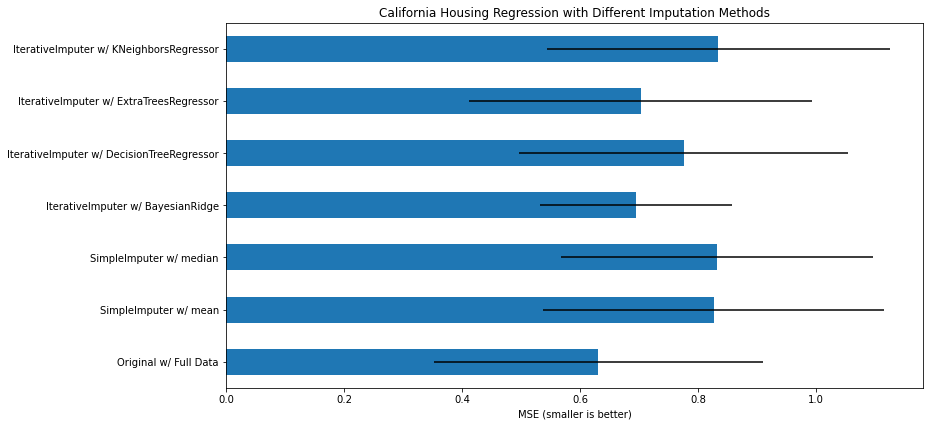

In [21]:


# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

# Appendix

In [7]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
cross_val_score(lasso, X, y, cv=3)


array([0.33150734, 0.08022311, 0.03531764])

In [8]:
X.shape

(150, 10)

In [14]:
np.sqrt(2000)

44.721359549995796